In [1]:
!pip3 install lightning torchvision matplotlib pandas

In [2]:
# from torchvision.model import resnet18
import lightning
import matplotlib.pyplot as plt 
import pandas as pd
import torchvision
import numpy as np
from shared import * 
from lightning.pytorch.loggers import CSVLogger


In [3]:
torch.manual_seed(123)

In [4]:
from torch import device
from torchvision import transforms 

# Define transforms
selfsupervised_transforms = transforms.Compose([
    transforms.RandomResizedCrop(size=128),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([transforms.ColorJitter(0.8, 0.8, 0.8, 0.2)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.GaussianBlur(kernel_size=9, sigma=(0.1, 0.5)),
    transforms.ToTensor()
])

# Define augmentation class
class AugmentImg:
    def __init__(self, transform):
        self.transform = transform
    def __call__(self, x):
        return [self.transform(x), self.transform(x)]

# Initialize DataModule with transforms
# dm = Cifar10DataModule(
#     batch_size=64,
#     train_transform=AugmentImg(selfsupervised_transforms),
#     test_transform=AugmentImg(selfsupervised_transforms)
# )

# # Setup data
# dm.prepare_data()
# dm.setup('fit')

In [5]:
# for images,_ in  dm.train_dataloader():
#     break

# # print(len(images))
# images[0].shape

In [6]:
# images[0][5].shape

In [7]:
# paired=[]
# for i in range(64):
#     paired.append(images[0][i])
#     paired.append(images[1][i])


# plt.Figure(figsize=(8,8))
# plt.imshow(np.transpose(torchvision.utils.make_grid(paired[:64], nrow=8, padding=2,normalize=True),(1,2,0)))
# plt.title('Normal Image + Augment Image')
# plt.axis('off')
# plt.show()

# Make 2 Full Connected Layer

In [8]:
pytorch_model = torch.hub.load('pytorch/vision', 'resnet18', weights=False)

pytorch_model.fc = torch.nn.Sequential(
    # Hidden Layer
    torch.nn.Linear(512, 512),
    torch.nn.ReLU(),
    # Output Layer
    torch.nn.Linear(512, 256) #Output: Get the embeddings
    ) 




Using cache found in /home/zeus/.cache/torch/hub/pytorch_vision_main
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [9]:
# NCE Loss (New thing)
# https://github.dev/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial17/SimCLR.ipynb

def info_nce_loss (feats, temperature, mode="train"):
        

        # Calculate cosine similarity
        cos_sim = F.cosine_similarity(feats[:,None,:], feats[None,:,:], dim=-1)
        # print("cos_sim.shape:",cos_sim.shape)

        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
        # print("self_mask.shape:", self_mask.shape)

        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0]//2, dims=0)
        # print("pos_mask.shape:", pos_mask.shape)

        # InfoNCE loss
        cos_sim = cos_sim /temperature
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()
        # print("nll.shape:", nll.shape)
        
        # Get ranking position of positive example
        comb_sim = torch.cat([cos_sim[pos_mask][:,None],  # First position positive example
                              cos_sim.masked_fill(pos_mask, -9e15)], 
                             dim=-1)
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
       
        return nll,sim_argsort


In [10]:
class LightningModelSimCLR(L.LightningModule):
    def __init__(self,model,learning_rate,temprature):
        super().__init__()

        self.model = model
        self.learning_rate = learning_rate
        self.temprature = temprature

        self.save_hyperparameters(ignore=['model'])

    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        image,_ = batch
        images = torch.cat(image, dim=0)
        transforms_fead = self(images)

        loss,sim_argsort = info_nce_loss(transforms_fead,mode="train",temperature= self.temprature)
        self.log("train_loss", loss,prog_bar=True)
        self.log("train_acc", (sim_argsort < 5).float().mean(),prog_bar=True)

        return loss
    
    def validation_step(self, batch, batch_idx):
        image,_ = batch
        images = torch.cat(image, dim=0)
        transforms_fead = self(images)

        loss,sim_argsort = info_nce_loss(transforms_fead,mode="val",temperature= self.temprature)
        self.log("val_loss", loss,prog_bar=True)
        self.log("val_acc", (sim_argsort < 5).float().mean(),prog_bar=True)
        return loss
    
    def configure_optimizers(self):
        optmizer= torch.optim.Adam(self.parameters(),lr=self.learning_rate)
        return optmizer
    
    
    # 

# Data Loading
dm = Cifar10DataModule(
    batch_size=256,
    num_workers=5,
    train_transform=AugmentImg(selfsupervised_transforms),
    test_transform=AugmentImg(selfsupervised_transforms),
    )

LightningModel_duplicate = LightningModelSimCLR(
    model=pytorch_model,
    learning_rate=0.0005,
    temprature=0.07
)


In [11]:
trainer = L.Trainer(
    max_epochs=50,
    accelerator="auto",
    devices="auto",
logger=CSVLogger(save_dir="logs/", name="mine_model")
)

trainer.fit(LightningModel_duplicate, dm)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA L40S') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params | Mode 
-----------------------------------------
0 | model | ResNet | 11.6 M | train
-----------------------------------------
11.6 M    Trainable params
0         Non-trainable params
11.6 M    Total params
46.282    Total estimated model params size (MB)
71        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


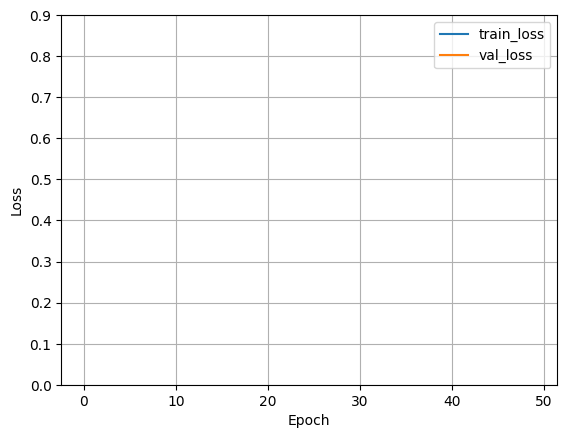

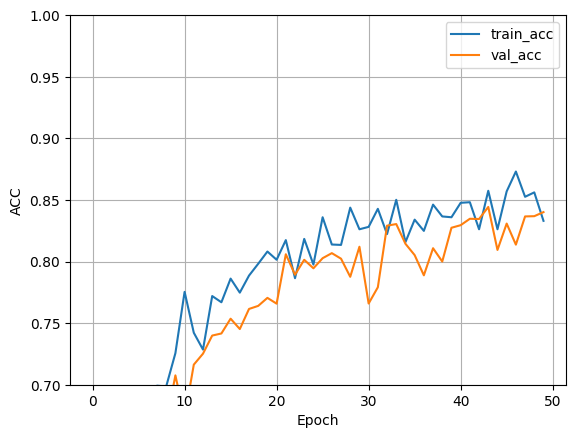

In [ ]:

def plot_loss_and_acc(
    log_dir, loss_ylim=(0.0, 0.9), acc_ylim=(0.7, 1.0), save_loss=None, save_acc=None):

    metrics = pd.read_csv(f"{log_dir}/metrics.csv")

    aggreg_metrics = []
    agg_col = "epoch"
    for i, dfg in metrics.groupby(agg_col):
        agg = dict(dfg.mean())
        agg[agg_col] = i
        aggreg_metrics.append(agg)

    df_metrics = pd.DataFrame(aggreg_metrics)
    df_metrics[["train_loss", "val_loss"]].plot(
        grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
    )
    df_metrics[["train_acc", "val_acc"]].plot(
        grid=True, legend=True, xlabel="Epoch", ylabel="acc"
    )

   
    plt.show()


plot_loss_and_acc('logs/mine_model/version_2')
# trainer.logger.log_dir